## 각 feature의 데이터 종류를 뜯어보자. 
+ 수치형
    + 연속형
    + 이산형
+ 범주형

각 변수의 데이터 종류
+ sessionID: 각 세션을 표현하는 Key값. 중복없음.
+ [userID](##userID) : string. User의 고유 ID. 80%의 유저는 한번의 session을 발생시킴. 2번 이상 접속한 인원은 26258명
+ [TARGET](##target) : 수치/연속형 자료. 고객이 머무른 시간. 값의 범위는 1.0 ~ 386.0. float형이지만 모두 정수값만 있음.
+ [browser](##browser) : 범주형. 어떤 browser에서 session이 만들어졌는지. 70개의 브라우저가 사용됨. 특히 빈도가 1인 값들은 특정 브라우저를 알 수 없는 값. Null로 간주해도 될 것으로 보임
+ [OS](##OS) : 범주형. 어떤 OS에서 session이 만들어졌는지. 20개의 OS가 사용됨. Null 값이 존재하는데, (not set)이란 형태로 되어있다.
+ [devices](##device) : 범주형. 어떤 기기에서 session이 만들어졌는지. 3개의 데이터가 사용됨. 66%가 PC, 30%가 mobile, 나머지 약 4%가 tablet
+ [new](##new) :  True or False. user의 첫방문 여부. 새로1과 0으로 기록되어 있음.
+ [quality](##quality) : 세션의 질(거래 성사를 기준으로 측정된 값). 값의 범위 1~100. train에서는 98.0까지만 값이 존재함. 대부분의 값(약 80%)이 1.0
+ [duration](##duration) : numerical value. not null. 총 세선 시간(각 세션의 시간을 모두 더한 것. 세션은 뭐지?)
+ [bounced](##bounced) : 1 or 0, 이탈 여부. not null. 그런데 모든 user는 결국 session을 떠나지 않나? 어떤 것이 떠나는 기준인지 궁금하다. 평균이 0.5 미만인 것을 보았을 때, 절반 정도의 사람이 이 세션을 끝내고 있음.
+ [transaction](##transaction) : numerical value, not null. 세션 내에서 발생한 거래 수. train data에서 사용된 값은 총 8개. [0.0, 1.0, 3.0, 4.0, 5.0, 7.0, 12.0]
+ [transaction_revenue](##transaction_revenue) : 총 거래 수익. 소수점 이하 데이터 없음. 실수형이지만, 정수형으로 사용해도됨. 최소값 0 최댓값 3325712000 평균 906124, 멱함수 분포. 대부분 0
+ [continent](##continent) : categorical value. null -> 336. null을 제외하고 5개의 대륙 데이터. 
+ [subcontinent](##subcontinent) : categorical value. null -> 336. null을 제외하고 22개의 sub대륙 데이터가 있음
+ [country](##country) : categorical value. null -> 336.
+ [traffic_source](##traffic_source) : 트래픽이 발생한 소스. categorical value. 다양한 브라우저 도메인이 있음. 전처리를 통해 형태가 다른 중복 데이터를 하나로 합칠 여지가 있다.
+ [traffic_medium](##traffic_medium) : ??


## Setting Data

In [62]:
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso

pd.options.display.float_format = '{:.5f}'.format

### Fixed Random-Seed
동일한 결과를 위한 seed 고정

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

### Load Data
train.csv, test.csv 파일을 불러오자.

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

## Show data sample and informations.

In [4]:
train.sample(5)

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
33522,SESSION_033522,USER_028550,10.0,Safari,iOS,tablet,1,2.0,329.0,0,0.0,0.0,Africa,Eastern Africa,Somalia,youtube.com,referral,NaN,Category11_Path_0073
19669,SESSION_019669,USER_017076,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
135170,SESSION_135170,USER_112194,3.0,Android Webview,Android,mobile,1,1.0,38.0,0,0.0,0.0,Africa,Northern Africa,Egypt,youtube.com,referral,NaN,Category2_Path_0256
33577,SESSION_033577,USER_028595,2.0,Edge,Windows,desktop,1,1.0,103.0,0,0.0,0.0,Americas,Northern America,United States,youtube.com,referral,NaN,Category11_Path_0012
138451,SESSION_138451,USER_114822,2.0,Android Webview,Android,mobile,1,1.0,31.0,0,0.0,0.0,Africa,Northern Africa,Egypt,youtube.com,referral,NaN,Category2_Path_0256


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sessionID            252289 non-null  object 
 1   userID               252289 non-null  object 
 2   TARGET               252289 non-null  float64
 3   browser              252289 non-null  object 
 4   OS                   252289 non-null  object 
 5   device               252289 non-null  object 
 6   new                  252289 non-null  int64  
 7   quality              252289 non-null  float64
 8   duration             252289 non-null  float64
 9   bounced              252289 non-null  int64  
 10  transaction          252289 non-null  float64
 11  transaction_revenue  252289 non-null  float64
 12  continent            252289 non-null  object 
 13  subcontinent         252289 non-null  object 
 14  country              252289 non-null  object 
 15  traffic_source   

In [6]:
# 각 변수 별 고유값 확인
for col in train.columns.to_list():
    print(f"{col} : {train[col].nunique()}")

sessionID : 252289
userID : 206024
TARGET : 117
browser : 70
OS : 21
device : 3
new : 2
quality : 98
duration : 2972
bounced : 2
transaction : 8
transaction_revenue : 1218
continent : 6
subcontinent : 23
country : 205
traffic_source : 168
traffic_medium : 7
keyword : 623
referral_path : 1578


## userID

In [32]:
# 2번 이상 session을 발생시킨 인원을 구해보자. 
vc = train['userID'].value_counts()
vc_ = vc[vc >= 2]
len(vc_)

26258

## Target

In [53]:
# 타겟의 고유값 종류를 살펴봄
target_vc = train['TARGET'].value_counts()
# target_vc = target_vc[target_vc >= 2]
display(target_vc.index.sort_values())
display(target_vc.unique())
display(target_vc.nunique())

Index([  1.0,   2.0,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,   9.0,  10.0,
       ...
       157.0, 161.0, 171.0, 176.0, 198.0, 199.0, 224.0, 270.0, 283.0, 386.0],
      dtype='float64', name='TARGET', length=117)

array([126008,  33690,  23636,  14291,  10743,   7720,   6181,   4836,
         3865,   3066,   2695,   2153,   1827,   1545,   1275,   1099,
          984,    758,    678,    551,    529,    482,    374,    354,
          309,    283,    226,    207,    167,    164,    139,    127,
          115,    108,     85,     80,     78,     71,     70,     60,
           51,     48,     43,     41,     38,     31,     25,     22,
           21,     20,     16,     15,     14,     12,     11,     10,
            7,      6,      5,      3,      2,      1], dtype=int64)

62

In [57]:
x = train['TARGET']

result = x.apply(lambda x: x- int(x))
result[result != 0.0]

Series([], Name: TARGET, dtype: float64)

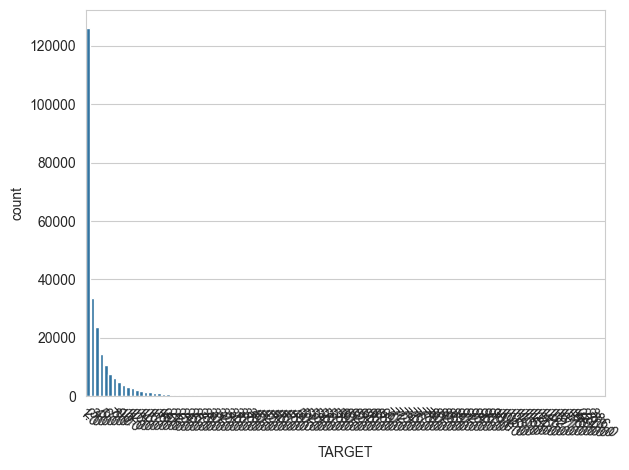

In [51]:
sns.barplot(target_vc)
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

## Browser

In [62]:
display(train['browser'].unique())
display(len(train['browser'].unique()))

array(['Chrome', 'Samsung Internet', 'Firefox', 'Opera',
       'Safari (in-app)', 'Edge', 'Safari', 'Android Webview',
       'UC Browser', 'Internet Explorer', 'Opera Mini', 'BlackBerry',
       'Android Browser', 'Amazon Silk', 'Coc Coc', 'YaBrowser',
       'Nintendo Browser', 'Nokia Browser', 'MRCHROME', 'Puffin',
       'Mozilla Compatible Agent', 'Maxthon', '+Simple Browser',
       'Apple-iPhone7C2', 'Playstation Vita Browser',
       'osee2unifiedRelease', 'SAMSUNG-SM-B355E Opera', 'DESKTOP', 'Iron',
       'Browser', 'rpfanjzoxyemsgbtichqkudwlv',
       'cajrnbtvqwfkolzyxushpdgime', 'wvsmagudcqeytijorlhxnfzkbp',
       'efkaxnbyohqtspzlvcwrjmigdu', 'bsfnwveckhgpdoyjxmizruqtla',
       'Mozilla', 'Konqueror', 'Netscape', 'Amazon.com', 'SeaMonkey',
       ';__CT_JOB_ID__:76fd1acb-e365-43c0-b967-908bcf5d5b59;',
       'eosutpkiahjzvdgcwxlmyfqbrn', 'cnwmpegudakrqzljtvfxohbysi',
       'fspmihbxzowgnuctrqykjlvade', 'YE',
       ';__CT_JOB_ID__:7e575295-571e-4e82-9254-7f2c8bbb9183;

70

In [66]:
browser_vc = train['browser'].value_counts()
display(browser_vc[browser_vc == 1])
display(browser_vc[browser_vc > 1])

browser
bsfnwveckhgpdoyjxmizruqtla                              1
;__CT_JOB_ID__:a80e8e16-6e98-455b-885a-a4dd40f3d344;    1
;__CT_JOB_ID__:4333777f-bb0c-4a18-935e-df5658dbce2d;    1
;__CT_JOB_ID__:2547db0b-ec43-452a-a0d4-ff42b7dc7907;    1
;__CT_JOB_ID__:2e0eca60-83ab-482d-bb81-343d113254fb;    1
;__CT_JOB_ID__:a7ed0808-e70c-4b19-b1a3-1018bbb7dc7f;    1
;__CT_JOB_ID__:85da5736-a78e-45a9-837e-f5a53e5cd725;    1
;__CT_JOB_ID__:a24a8978-e5e8-4dc9-af66-c4ed89ea25d7;    1
;__CT_JOB_ID__:89e59554-ad41-4e94-957b-f12bd012530c;    1
Netscape                                                1
Lunascape                                               1
;__CT_JOB_ID__:0b39e7ca-1431-42e3-ba1f-9d8951a65840;    1
;__CT_JOB_ID__:6e9dcf2f-f58f-4938-91e3-77e00868177b;    1
starmaker                                               1
;__CT_JOB_ID__:97909e28-4228-4b55-8ad5-cc791f2b583c;    1
;__CT_JOB_ID__:0a075729-93a5-43d0-9638-4cbd41d5f5a5;    1
;__CT_JOB_ID__:58e2ecba-7666-4a10-b498-8216457ce472;    1
;__CT_

browser
Chrome                      174395
Safari                       35689
Android Webview              13855
Firefox                       8436
Internet Explorer             4573
Edge                          3702
Samsung Internet              3077
Opera Mini                    3041
Safari (in-app)               1995
Opera                         1331
UC Browser                     901
YaBrowser                      402
Amazon Silk                    257
Coc Coc                        206
Mozilla Compatible Agent       124
Android Browser                110
Puffin                          55
MRCHROME                        15
Nokia Browser                   13
BlackBerry                      13
Maxthon                         11
Playstation Vita Browser         9
Nintendo Browser                 7
DESKTOP                          5
Iron                             4
SeaMonkey                        4
Konqueror                        3
Browser                          3
Mozilla     

## OS

In [67]:
train['OS'].value_counts()

OS
Windows             88119
Macintosh           60316
Android             51870
iOS                 29778
Linux                9562
Chrome OS            9222
(not set)            2592
Tizen                 321
Samsung               259
Windows Phone         128
OS/2                   36
Xbox                   31
BlackBerry             29
Playstation Vita        9
Nintendo 3DS            6
Firefox OS              4
FreeBSD                 3
SunOS                   1
Nintendo WiiU           1
SymbianOS               1
Nokia                   1
Name: count, dtype: int64

## device

In [69]:
display(train['device'].value_counts())
display(train['device'].value_counts(normalize=True))

device
desktop    167133
mobile      76460
tablet       8696
Name: count, dtype: int64

device
desktop    0.662466
mobile     0.303065
tablet     0.034468
Name: proportion, dtype: float64

## new 

user의 첫방문여부에 대한 칼럼일 것으로 예상됨. 이를 확인하기 위해 userID가 2번 이상 발생하는 data를 살펴보자. 

In [9]:
train['new']

0         0
1         1
2         1
3         1
4         0
         ..
252284    1
252285    0
252286    0
252287    1
252288    0
Name: new, Length: 252289, dtype: int64

In [12]:
userID_vc = train['userID'].value_counts()
userID_vc[userID_vc> 1]

userID
USER_002675    78
USER_000643    74
USER_002967    61
USER_002775    59
USER_006147    50
               ..
USER_120464     2
USER_054511     2
USER_099933     2
USER_054512     2
USER_096987     2
Name: count, Length: 26258, dtype: int64

In [13]:
train[train['userID'] == 'USER_096987']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
116394,SESSION_116394,USER_096987,1.0,Chrome,Windows,desktop,1,1.0,0.0,1,0.0,0.0,Europe,Southern Europe,Kosovo,google,cpc,Category10,NaN
116395,SESSION_116395,USER_096987,1.0,Chrome,Windows,desktop,0,1.0,0.0,1,0.0,0.0,Europe,Southern Europe,Kosovo,google,cpc,Category10,NaN


In [14]:
train[train['userID'] == 'USER_054512']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
65984,SESSION_065984,USER_054512,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Asia,Eastern Asia,Taiwan,(direct),(none),NaN,NaN
66161,SESSION_066161,USER_054512,7.0,Chrome,Macintosh,desktop,0,2.0,22.0,0,0.0,0.0,Asia,Eastern Asia,Taiwan,(direct),(none),NaN,NaN


In [15]:
train[train['userID'] == 'USER_099933']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
120036,SESSION_120036,USER_099933,15.0,Chrome,Android,mobile,1,1.0,296.0,0,0.0,0.0,Asia,Southern Asia,India,youtube.com,referral,NaN,Category13_Path_0007
121028,SESSION_121028,USER_099933,3.0,Chrome,Android,mobile,0,1.0,181.0,0,0.0,0.0,Asia,Southern Asia,India,youtube.com,referral,NaN,Category13_Path_0007


## quality

<Axes: xlabel='quality', ylabel='Count'>

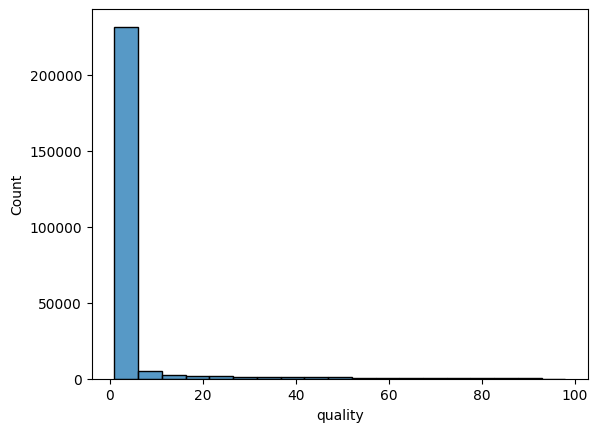

In [16]:
sns.histplot(data=train, x='quality')

In [23]:
train['quality'].value_counts(normalize=True)

quality
1.0     0.797934
2.0     0.066261
3.0     0.024072
4.0     0.013203
5.0     0.008902
          ...   
93.0    0.000099
95.0    0.000087
96.0    0.000040
97.0    0.000020
98.0    0.000008
Name: proportion, Length: 98, dtype: float64

In [19]:
train[train['quality']==99]

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path


## duration

In [40]:
train['duration'].isnull().sum()

0

In [37]:
train['duration']

0         839.0
1          39.0
2           0.0
3           0.0
4           0.0
          ...  
252284      0.0
252285      0.0
252286     69.0
252287     28.0
252288     77.0
Name: duration, Length: 252289, dtype: float64

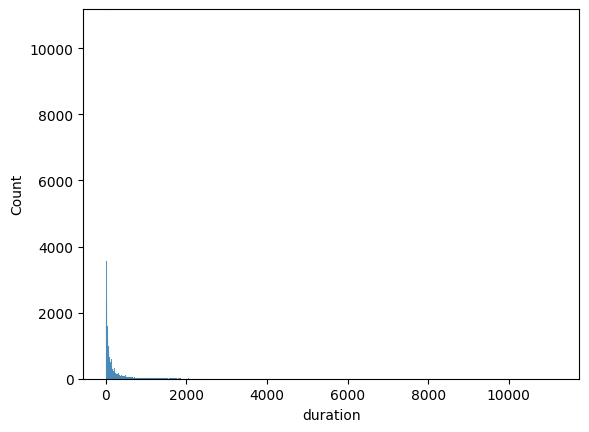

In [36]:
sns.histplot(data=train, x='duration')
# plt.xlim(2)
plt.ylim(top=11186)
plt.show()

In [34]:
max(train['duration'])

11186.0

## bounced

In [41]:
train['bounced']

0         0
1         0
2         1
3         1
4         1
         ..
252284    1
252285    1
252286    0
252287    0
252288    0
Name: bounced, Length: 252289, dtype: int64

In [42]:
train['bounced'].isnull().sum()

0

In [43]:
train['bounced'].mean()

0.49367193971992435

## transaction

In [16]:
train['transaction'].isnull().sum()

0

In [17]:
transac_vc = train['transaction'].value_counts()
transac_vc

transaction
0.0     250081
1.0       2162
2.0         38
3.0          3
4.0          2
5.0          1
7.0          1
12.0         1
Name: count, dtype: int64

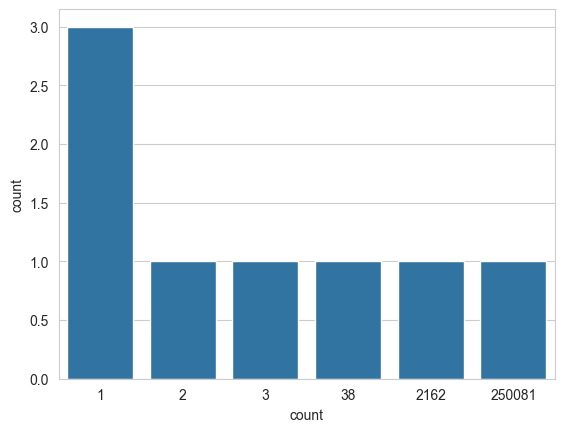

In [20]:
sns.countplot(x=transac_vc)
plt.show()

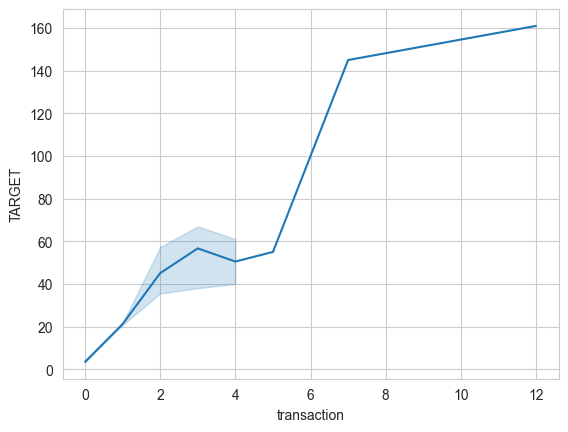

In [13]:
sns.lineplot(data=train, x='transaction', y='TARGET')
plt.show()

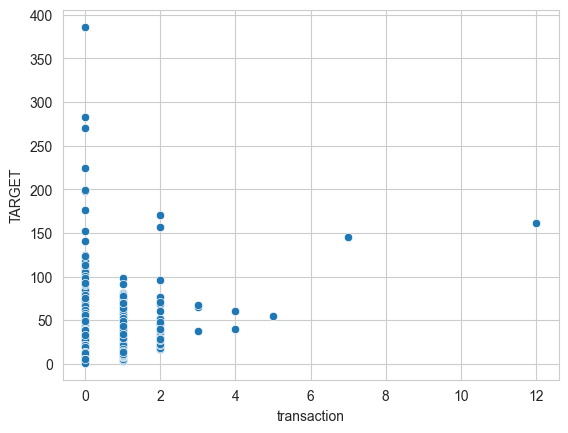

In [7]:
sns.set_style(style='whitegrid')
sns.scatterplot(data=train, x='transaction', y='TARGET')
plt.show()

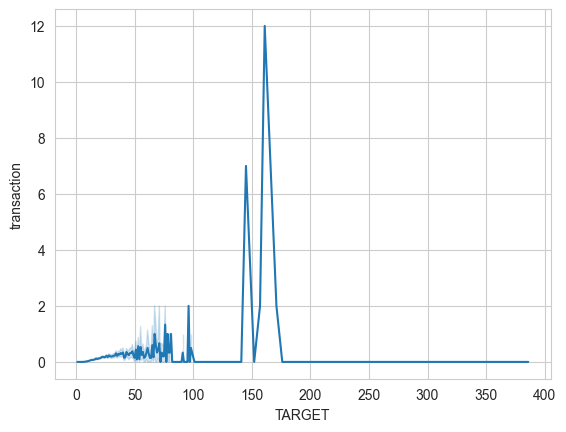

In [14]:
sns.lineplot(data=train, x='TARGET', y='transaction')
plt.show()

<Axes: xlabel='TARGET', ylabel='transaction'>

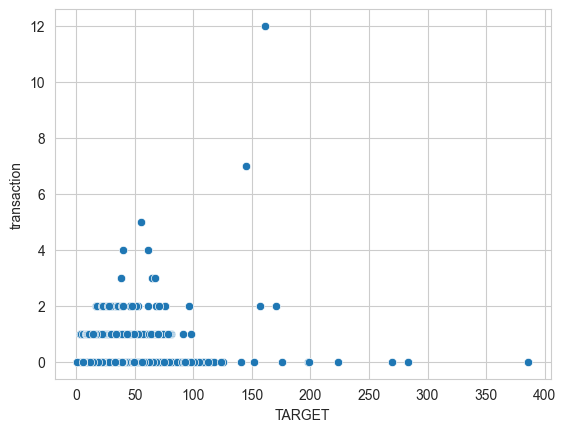

In [15]:
sns.scatterplot(data=train, x='TARGET', y='transaction')

In [21]:
train[train['transaction'] == 12.0]

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
100318,SESSION_100318,USER_039312,161.0,Chrome,Macintosh,desktop,0,87.0,4148.0,0,12.0,649821280.0,Americas,Northern America,United States,(direct),(none),NaN,Category1


In [22]:
train[train['userID'] ==  'USER_039312']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
46934,SESSION_046934,USER_039312,9.0,Chrome,Macintosh,desktop,1,27.0,258.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
47016,SESSION_047016,USER_039312,1.0,Chrome,Macintosh,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
100318,SESSION_100318,USER_039312,161.0,Chrome,Macintosh,desktop,0,87.0,4148.0,0,12.0,649821280.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
101470,SESSION_101470,USER_039312,10.0,Chrome,Macintosh,desktop,0,56.0,113.0,0,1.0,23212960.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
113728,SESSION_113728,USER_039312,5.0,Chrome,Macintosh,desktop,0,2.0,60.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
116132,SESSION_116132,USER_039312,5.0,Chrome,Macintosh,desktop,0,2.0,38.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
125750,SESSION_125750,USER_039312,4.0,Chrome,Macintosh,desktop,0,2.0,82.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1


## transaction_revenue

In [64]:
tr = train['transaction_revenue']
tr.sample(10)

76123    0.00000
24428    0.00000
71196    0.00000
162381   0.00000
151384   0.00000
55244    0.00000
223309   0.00000
70044    0.00000
244156   0.00000
52988    0.00000
Name: transaction_revenue, dtype: float64

In [63]:
tr.describe()

count       252289.00000
mean        906124.82922
std       21276887.17141
min              0.00000
25%              0.00000
50%              0.00000
75%              0.00000
max     3325712000.00000
Name: transaction_revenue, dtype: float64

In [66]:
# 소수점 이하의 데이터가 있는지 살펴보자.
decimal = tr.apply(lambda x: x-int(x))
decimal[decimal != 0.0]

Series([], Name: transaction_revenue, dtype: float64)

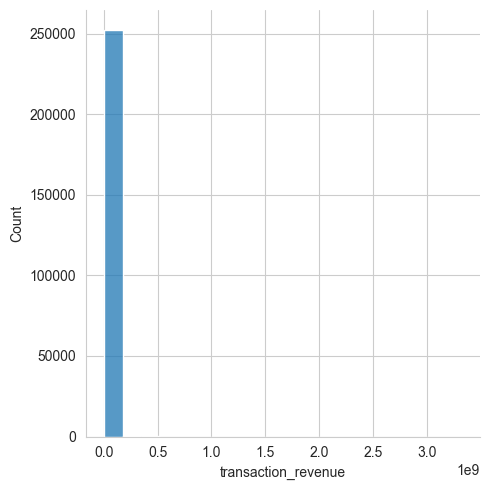

In [43]:
sns.displot(train['transaction_revenue'])
plt.show()

In [54]:
tr = train[train['transaction_revenue']>=1]
tr

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
118,SESSION_000118,USER_000116,17.0,Chrome,Macintosh,desktop,1,64.0,1318.0,0,1.0,26620800.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
352,SESSION_000352,USER_000339,18.0,Chrome,Windows,desktop,0,68.0,668.0,0,1.0,53798560.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
1499,SESSION_001499,USER_001383,22.0,Chrome,Windows,desktop,1,28.0,548.0,0,1.0,60869120.0,Americas,Northern America,United States,google,organic,Category8,NaN
1862,SESSION_001862,USER_001710,16.0,Chrome,Chrome OS,desktop,0,91.0,883.0,0,1.0,7363200.0,Americas,Northern America,United States,(direct),(none),NaN,Category6_Path_0008
2764,SESSION_002764,USER_002529,20.0,Chrome,Android,mobile,1,46.0,1735.0,0,1.0,70771680.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251856,SESSION_251856,USER_205705,30.0,Chrome,Android,mobile,1,42.0,3526.0,0,1.0,16982560.0,Americas,Northern America,United States,google,organic,Category8,NaN
251972,SESSION_251972,USER_200686,15.0,Chrome,Macintosh,desktop,0,74.0,495.0,0,1.0,22835360.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252017,SESSION_252017,USER_197239,34.0,Chrome,Macintosh,desktop,0,69.0,723.0,0,1.0,156052640.0,Americas,Northern America,United States,google,organic,Category8,NaN
252036,SESSION_252036,USER_204007,43.0,Chrome,Windows,desktop,0,66.0,852.0,0,1.0,20739680.0,Americas,Northern America,United States,google,organic,Category8,NaN


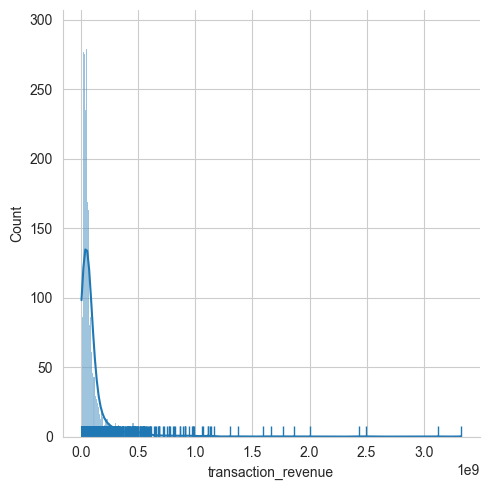

In [57]:
sns.displot(x=tr['transaction_revenue'], kde=True, rug=True)
plt.show()

In [46]:
tr_vc=train['transaction_revenue'].value_counts()
log_tr_vc = np.log(tr_vc)

<Axes: xlabel='count', ylabel='Density'>

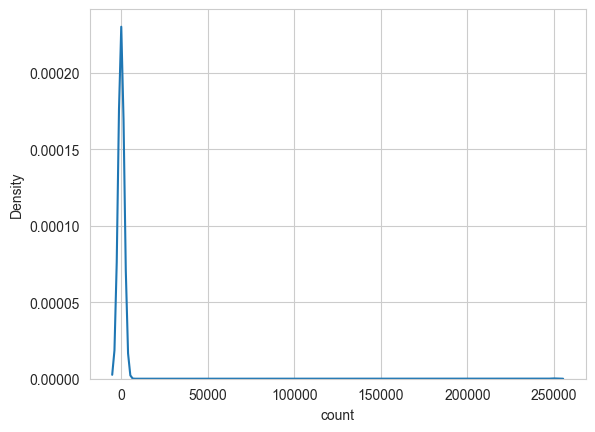

In [53]:
sns.kdeplot(tr_vc)

In [51]:
log_tr_vc

transaction_revenue
0.0            12.429564
43405120.0      3.433987
46237120.0      3.295837
40573120.0      3.258097
42461120.0      3.218876
                 ...    
216478080.0     0.000000
165181120.0     0.000000
90350240.0      0.000000
68770400.0      0.000000
461559360.0     0.000000
Name: count, Length: 1218, dtype: float64

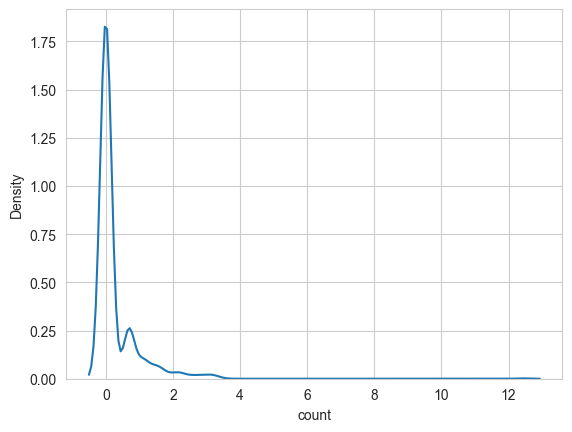

In [52]:
sns.kdeplot(x=log_tr_vc)
plt.show()

<Axes: xlabel='transaction_revenue'>

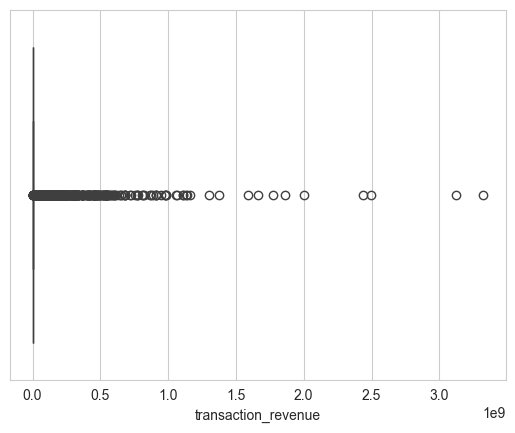

In [32]:
# box plot으로 보기
sns.boxplot(x = train['transaction_revenue'])

### log 변환
pow 분포를 가지는 데이터셋을 분석할 때 데이터의 분포를 정규 분포에 가깝게 만들어줌.  
데이터 분포의 왜곡을 줄이고 데이터를 정규 분포에 가깝게 만들어 준다. 

c:\Users\kyeul\Desktop\code\dacon\Hackerthon-predict_on_web_log\.conda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


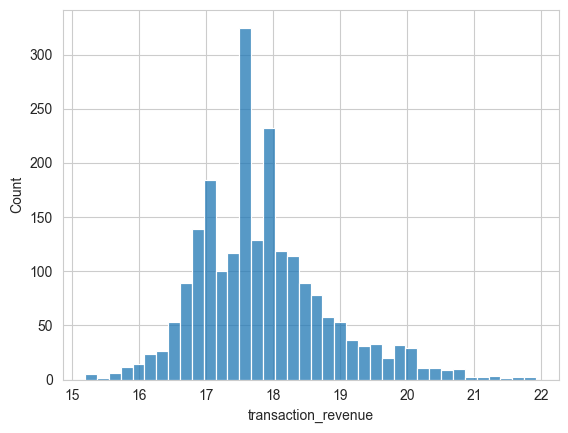

In [33]:
log_tr = np.log(train['transaction_revenue'])
sns.histplot(x=log_tr)
plt.show()

## continent

In [67]:
conti = train['continent']

In [68]:
# show samples
conti.sample(10)

64125         Asia
192372      Europe
51720     Americas
56529     Americas
67980     Americas
198856    Americas
211438    Americas
73383         Asia
46347       Europe
14278     Americas
Name: continent, dtype: object

In [72]:
# show vc
conti_vc = conti.value_counts()
conti_vc

continent
Americas     126506
Asia          57254
Europe        53748
Africa        10514
Oceania        3931
(not set)       336
Name: count, dtype: int64

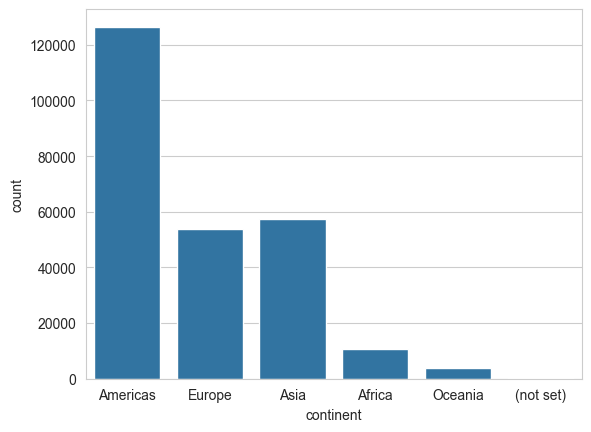

In [77]:
sns.countplot(data=train, x='continent')
plt.show()

In [71]:
train[train['continent']=='(not set)']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
978,SESSION_000978,USER_000912,1.00000,Safari (in-app),iOS,mobile,1,1.00000,0.00000,1,0.00000,0.00000,(not set),(not set),(not set),google,cpc,Category9,NaN
1065,SESSION_001065,USER_000991,1.00000,Chrome,Android,mobile,1,1.00000,0.00000,1,0.00000,0.00000,(not set),(not set),(not set),(direct),(none),NaN,NaN
2012,SESSION_002012,USER_001844,4.00000,Chrome,Windows,desktop,1,1.00000,39.00000,0,0.00000,0.00000,(not set),(not set),(not set),(direct),(none),NaN,NaN
2781,SESSION_002781,USER_002546,1.00000,Chrome,Android,mobile,0,1.00000,0.00000,1,0.00000,0.00000,(not set),(not set),(not set),(direct),(none),NaN,NaN
3077,SESSION_003077,USER_002546,2.00000,Chrome,Android,mobile,0,1.00000,8.00000,0,0.00000,0.00000,(not set),(not set),(not set),(direct),(none),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250035,SESSION_250035,USER_204316,1.00000,Chrome,Windows,desktop,1,1.00000,0.00000,1,0.00000,0.00000,(not set),(not set),(not set),google,organic,Category8,NaN
250612,SESSION_250612,USER_204769,1.00000,Chrome,Windows,desktop,1,1.00000,0.00000,1,0.00000,0.00000,(not set),(not set),(not set),analytics.google.com,referral,NaN,Category3_Path_0013
250654,SESSION_250654,USER_204805,3.00000,Chrome,Windows,desktop,1,1.00000,33.00000,0,0.00000,0.00000,(not set),(not set),(not set),google,organic,Category8,NaN
251144,SESSION_251144,USER_205183,1.00000,Internet Explorer,Windows,desktop,1,1.00000,0.00000,1,0.00000,0.00000,(not set),(not set),(not set),youtube.com,referral,NaN,Category13_Path_0029


## subcontinent

In [78]:
subconti = train['subcontinent']
subconti

0         Northern America
1           Western Europe
2           Southeast Asia
3         Northern America
4         Northern America
                ...       
252284     Northern Europe
252285    Northern America
252286    Northern America
252287     Northern Africa
252288    Northern America
Name: subcontinent, Length: 252289, dtype: object

In [82]:
display(subconti.value_counts())
display(len(subconti.value_counts()))

subcontinent
Northern America      111945
Southern Asia          21744
Western Europe         18325
Northern Europe        15432
Southeast Asia         13977
Eastern Asia           13598
Southern Europe        10752
South America           9791
Eastern Europe          9239
Western Asia            7677
Northern Africa         5534
Central America         4201
Australasia             3895
Southern Africa         2164
Western Africa          1971
Eastern Africa           655
Caribbean                569
(not set)                336
Central Asia             258
Middle Africa            190
Micronesian Region        18
Melanesia                 10
Polynesia                  8
Name: count, dtype: int64

23

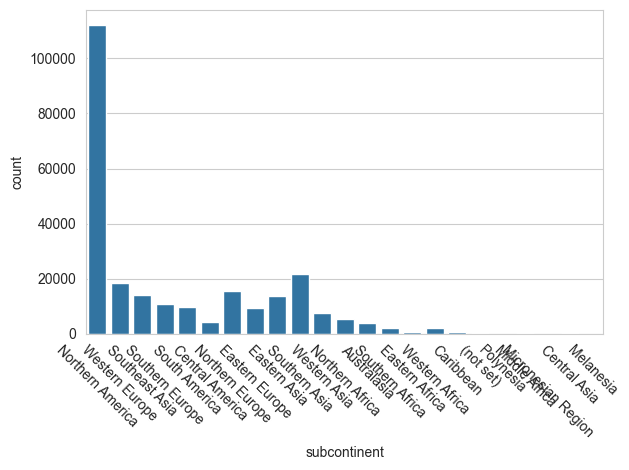

In [81]:
sns.countplot(data=train, x='subcontinent')
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

## country

In [83]:
country = train['country']
country.sample(10)

244727           Canada
92644            France
238014    United States
27404     United States
141962          Belgium
11257            France
225713    United States
146044    United States
218266            India
120096     South Africa
Name: country, dtype: object

In [86]:
country_vc = country.value_counts()
country_vc

country
United States               104201
India                        19300
United Kingdom               10019
Canada                        7735
Germany                       6319
                             ...  
St. Kitts & Nevis                1
Syria                            1
Bhutan                           1
Northern Mariana Islands         1
Vanuatu                          1
Name: count, Length: 205, dtype: int64

In [88]:
country_vc[country_vc==1]

country
Papua New Guinea            1
Mayotte                     1
Micronesia                  1
Central African Republic    1
Liechtenstein               1
Isle of Man                 1
Tajikistan                  1
St. Kitts & Nevis           1
Syria                       1
Bhutan                      1
Northern Mariana Islands    1
Vanuatu                     1
Name: count, dtype: int64

In [91]:
country[country=='(not set)']

978       (not set)
1065      (not set)
2012      (not set)
2781      (not set)
3077      (not set)
            ...    
250035    (not set)
250612    (not set)
250654    (not set)
251144    (not set)
251665    (not set)
Name: country, Length: 336, dtype: object

In [89]:
country.nunique()

205

In [90]:
country_vc.nunique()

135

In [85]:
country.info()

<class 'pandas.core.series.Series'>
RangeIndex: 252289 entries, 0 to 252288
Series name: country
Non-Null Count   Dtype 
--------------   ----- 
252289 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB


## traffic_source

In [92]:
ts = train['traffic_source']
ts.sample(10)

40371          google
190226       (direct)
194970    youtube.com
231326         google
207897         google
199644       (direct)
197857         google
42389          google
204707    youtube.com
222020         google
Name: traffic_source, dtype: object

In [107]:
ts_vc = ts.value_counts()

In [110]:
ts.unique()

array(['google', '(direct)', 'Partners', 'groups.google.com',
       'youtube.com', 'google.com', 'bing', 'google.co.jp',
       'analytics.google.com', 'baidu', 'quora.com',
       'googleads.g.doubleclick.net', 'pinterest.com', 'mail.google.com',
       'dealspotr.com', 'qiita.com', 'l.facebook.com', 'reddit.com',
       'sites.google.com', 'blog.golang.org', 'support.google.com',
       'yahoo', 'dfa', 't.co', 'lunametrics.com', 'docs.google.com',
       'adwords.google.com', 's0.2mdn.net', 'm.baidu.com',
       'm.facebook.com', 'int.search.tb.ask.com', 'google.com.br',
       'google.es', 'arstechnica.com', 'msn.com', 'tw.search.yahoo.com',
       'facebook.com', 'google.de', 'hangouts.google.com',
       'duckduckgo.com', 'r.search.aol.com', 'my.yahoo.com',
       'google.co.za', 'au.search.yahoo.com', 'in.search.yahoo.com',
       'outlook.live.com', 'productforums.google.com', 'ask',
       'google.co.id', 'google.co.uk', 'myactivity.google.com',
       'google.com.ua', 'google

In [102]:
ts_vc.index

Index(['google', '(direct)', 'youtube.com', 'analytics.google.com', 'Partners',
       'sites.google.com', 'google.com', 'bing', 'reddit.com', 'qiita.com',
       'quora.com', 'mail.google.com', 'baidu', 'dfa', 'away.vk.com',
       'groups.google.com', 'plus.url.google.com', 'facebook.com',
       'm.facebook.com', 'support.google.com'],
      dtype='object', name='traffic_source')

## traffic_medium

In [111]:
tm = train['traffic_medium']
tm.sample(10)

34899      organic
182509         cpc
96984     referral
132625     organic
159716    referral
16793      organic
85322     referral
169330      (none)
219282     organic
220066    referral
Name: traffic_medium, dtype: object

In [112]:
tm.unique()

array(['organic', '(none)', 'affiliate', 'referral', 'cpc', 'cpm',
       '(not set)'], dtype=object)

In [113]:
tm.value_counts()

traffic_medium
organic      107370
referral      70047
(none)        59022
cpc            9978
affiliate      5365
cpm             501
(not set)         6
Name: count, dtype: int64

In [114]:
train['keyword'].value_counts()

keyword
Category8                103584
Category9                  3488
Category11                 1931
Category10                 1147
Category6_Keyword_003       634
                          ...  
Category2_Keyword_273         1
Category1_Keyword_271         1
Category3_Keyword_270         1
Category4_Keyword_269         1
Category4_Keyword_617         1
Name: count, Length: 623, dtype: int64